In [1]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters

import sys
sys.path.append(r'../src/')

import importlib
import transform
importlib.reload(transform)

<module 'transform' from '../src\\transform.py'>

D:/Data/bujo_sample\20190309_125153.jpg


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


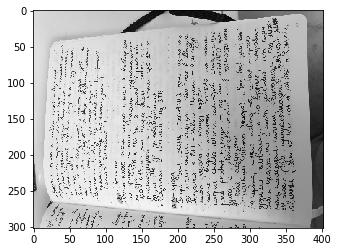

In [2]:
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[7])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

src2 = skimage.transform.rescale(src, scale=0.1)
plt.imshow(src2, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1.1166253101737027


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


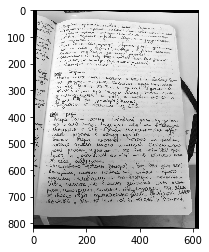

In [3]:
res = transform.get_text_angle(src2)
print(res[0][0])

src3 = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.2), -90.0-res[0][0], resize=True)
srcr = skimage.transform.rotate(src, -90.0-res[0][0], resize=True)
plt.imshow(src3, cmap='gray')

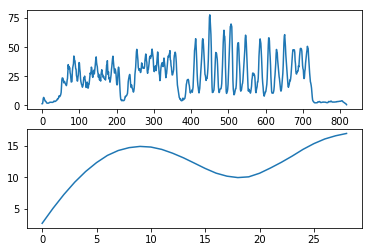

In [4]:
src3v = np.sum(np.abs(src3[:,1:]-src3[:,:-1]), axis=1)

src4 = np.array([np.mean(np.abs(src3v[i:]-src3v[:-i])) for i in range(1, 30)])
plt.subplot(211)
plt.plot(src3v)
plt.subplot(212)
plt.plot(src4)

In [39]:
def rolling_percentile_2d(arr, sz, q):
    res = np.zeros((sz[0]*sz[1], arr.shape[0] - sz[0] + 1, arr.shape[1] - sz[1] + 1))
    
    for i in range(sz[0]):
        for j in range(sz[1]):
            res[i*sz[1]+j, :, :] = arr[i:(arr.shape[0]-sz[0]+1+i),j:(arr.shape[1]-sz[1]+1+j)]
    
    return np.percentile(res, q, axis=0)

def calc_variance_percentile_v(src, filt_sz, q):
    var = np.cumsum(np.abs(src[1:,:]-src[:-1,:]), axis=0)
    mean = (var[filt_sz[0]:,:]-var[:-filt_sz[0],:]) / filt_sz[0]
    return rolling_percentile_2d(mean, (1, filt_sz[1]), q)

def calc_variance_percentile_h(src, filt_sz, q):
    var = np.cumsum(np.abs(src[:,1:]-src[:,:-1]), axis=1)
    mean = (var[:,filt_sz[1]:]-var[:,:-filt_sz[1]]) / filt_sz[1]
    return rolling_percentile_2d(mean, (filt_sz[0], 1), q)

def local_maxima_filter_v(src, i, d1, d2, cutoff):
    ilo1 = max(0, i-d1)
    ilo2 = max(0, i-d2)
    ihi1 = min(src.shape[0], i+d1+1)
    ihi2 = min(src.shape[0], i+d2+1)
    m1 = np.max(src[ilo1:ihi1], axis=0)
    m2 = np.max(src[ilo2:ihi2], axis=0)
    return (m1 >= m2)*(m2 > cutoff)

def convert_to_value_range(xres, vmin, vmax):
    xs, cnts = np.unique(np.append(xres[(xres>=vmin)&(xres<=vmax)], range(vmin, vmax+1)), return_counts=True)
    return cnts-1

def select_from_grid(grid, flt, i0, i1, j0, j1):
    return (grid[i0:i1, j0:j1, :]-grid[(i0+i1)//2, (j0+j1)//2, :])[flt[i0:i1, j0:j1]>0, :]

def select_angle_idx(grid, flt, i0, i1, j0, j1):
    val = max(abs(i1-i0), abs(j1-j0))
    tmp_grid = select_from_grid(grid, flt, i0, i1, j0, j1)
    tmpa = np.array([convert_to_value_range(tmp_grid[:, i], -val, val) for i in range(grid.shape[2])])
    tmps = np.std(tmpa, axis=1)
    if np.max(tmps) <= 0.0:
        return (np.nan, np.nan)
    idx = np.argmax(tmps)
    conf = np.max(tmps) / np.median(tmps)
    return (idx, conf)

def calc_angle_field(grid, flt, kernel_size, kernel_stride):
    return np.array([[select_angle_idx(grid, flt, i, i+kernel_size[0], j, j+kernel_size[1])
      for j in range(0, grid.shape[1]-kernel_size[1], kernel_stride[1])]
     for i in range(0, grid.shape[1]-kernel_size[1], kernel_stride[1])])

def produce_angle_field(src, angles, kernel_size, kernel_stride):
    grid = np.array([[(i, j) for j in range(src.shape[1])] for i in range(src.shape[0])])
    uvecs = np.array([np.cos(angles), np.sin(angles)])
    grid_ang = np.round(np.dot(grid, uvecs))
    return calc_angle_field(grid_ang, src, kernel_size, kernel_stride)

Wall time: 332 ms


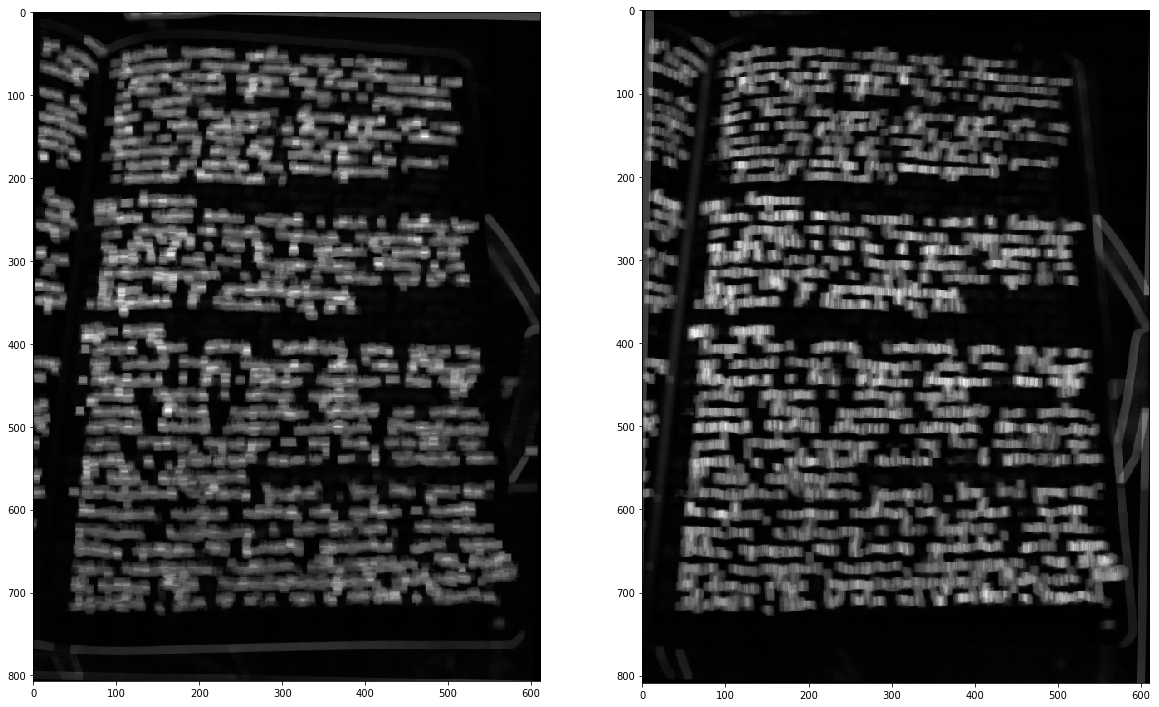

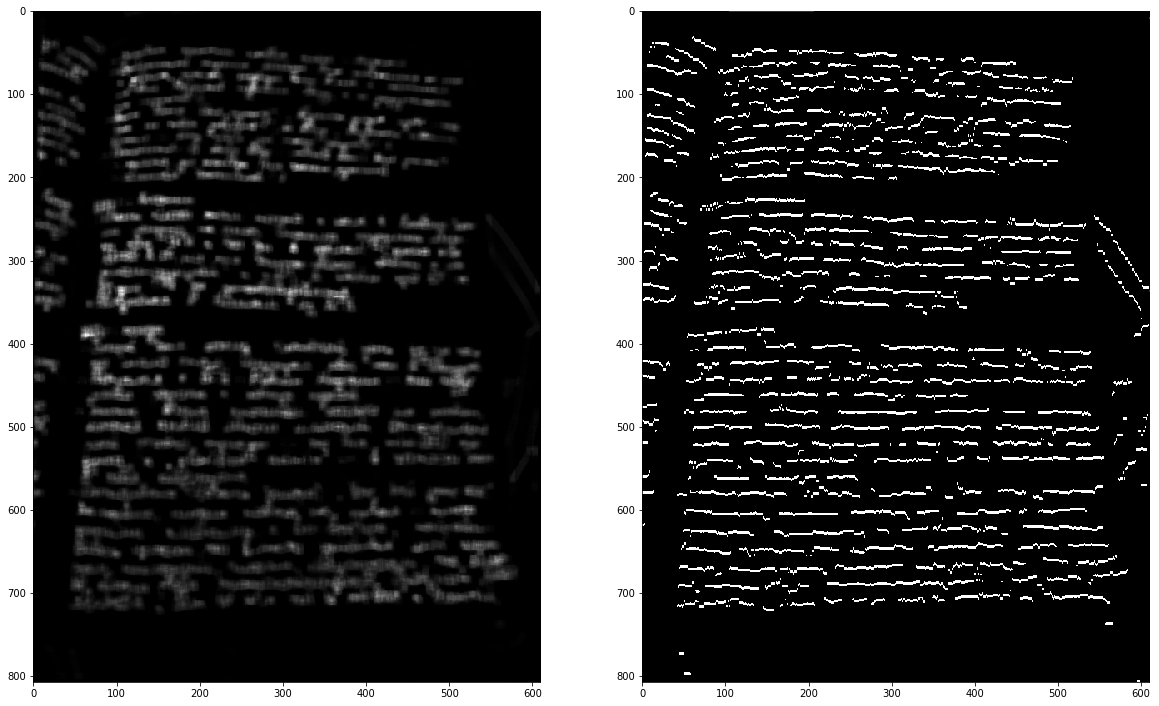

In [6]:
%%time
var_v = calc_variance_percentile_v(src3, (10,10), 70)
var_h = calc_variance_percentile_h(src3, (10,10), 70)
tmp = var_v[:,1:-1]*var_h[1:-1,:]
tmp2 = np.array([local_maxima_filter_v(tmp, i, 1, 10, 0.0015) for i in range(tmp.shape[0])])*1.0


plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(var_v, cmap='gray')
plt.subplot(122)
plt.imshow(var_h, cmap='gray')

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(tmp, cmap='gray')
plt.subplot(122)
plt.imshow(tmp2, cmap='gray')

In [7]:
%%time
theta = np.linspace(-np.pi/2, np.pi/2, 31)
grid = np.array([[(i, j) for j in range(tmp2.shape[1])] for i in range(tmp2.shape[0])])
uvecs = np.array([np.cos(theta), np.sin(theta)])
grid_theta = np.round(np.dot(grid, uvecs))

Wall time: 686 ms


In [22]:
%%time
tmp_grid = select_from_grid(grid_theta, tmp2, 0, 100, 0, 100)
tmpt = np.array([convert_to_value_range(tmp_grid[:,i], -50, 50) for i in range(grid_theta.shape[2])])

Wall time: 6.01 ms


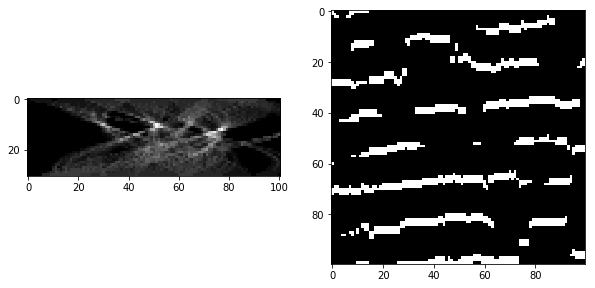

In [36]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(tmpt, cmap='gray')
plt.subplot(122)
plt.imshow(tmp2[100:200, 100:200], cmap='gray')

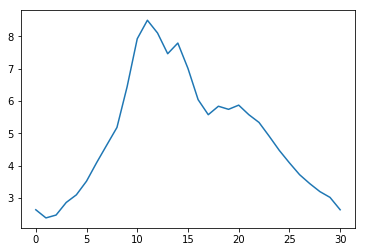

In [25]:
plt.plot(np.std(tmpt, axis=1))

In [37]:
theta[select_angle_idx(grid_theta, tmp2, 100, 200, 100, 200)[0]]*180/np.pi

5.999999999999996

Wall time: 1.26 s


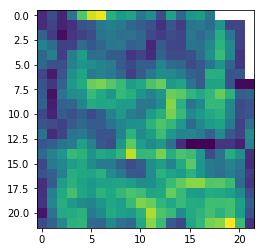

In [61]:
%%time
plt.imshow(produce_angle_field(tmp2, np.linspace(-np.pi/4, np.pi/4, 15), (75, 75), (25, 25))[:,:,1])

In [69]:
tmp2s2 = (skimage.transform.rescale(tmp2, scale=0.75)>0.1)*1.

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Wall time: 717 ms


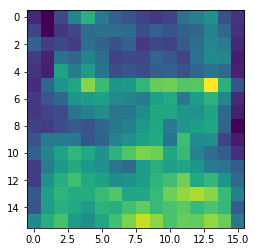

In [70]:
%%time
plt.imshow(produce_angle_field(tmp2s2, np.linspace(-np.pi/4, np.pi/4, 15), (75, 75), (25, 25))[:,:,1])